In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None

    def train_logistic_regression(self, X_train, y_train, X_val, y_val):
        """
        Train Logistic Regression with hyperparameter tuning.

        Hyperparameters to tune:
        - C: Regularization strength [0.1, 1.0, 10.0]
          C < 1: More regularization (simpler model)
          C > 1: Less regularization (complex model)

        Returns: (trained_model, metrics_dict)
        """
        param_grid = {'C': [0.1, 1.0, 10.0]}
        lr = LogisticRegression(max_iter=1000, random_state=42)
        grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1_weighted')
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)

        metrics = self._calculate_metrics(y_val, y_pred)
        self.models['Logistic Regression'] = best_model
        self.results['Logistic Regression'] = metrics

        return best_model, metrics

    def train_naive_bayes(self, X_train, y_train, X_val, y_val):
        """
        Train Naive Bayes (no hyperparameter tuning needed).
        Works well with sparse text features.

        Returns: (trained_model, metrics_dict)
        """
        # Scale X_train and X_val to be non-negative for MultinomialNB
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        nb = MultinomialNB()
        nb.fit(X_train_scaled, y_train)
        y_pred = nb.predict(X_val_scaled)

        metrics = self._calculate_metrics(y_val, y_pred)
        self.models['Naive Bayes'] = nb
        self.results['Naive Bayes'] = metrics

        return nb, metrics

    def train_knn(self, X_train, y_train, X_val, y_val):
        """
        Train K-Nearest Neighbors with hyperparameter tuning.

        Hyperparameters to tune:
        - n_neighbors: [3, 5, 7]
          k=3: More complex, follows data closely
          k=7: Simpler, more stable
        - metric: 'cosine' (better for sparse text)

        Returns: (trained_model, metrics_dict)
        """
        param_grid = {'n_neighbors': [3, 5, 7]}
        knn = KNeighborsClassifier(metric='cosine')
        grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted')
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)

        metrics = self._calculate_metrics(y_val, y_pred)
        self.models['KNN'] = best_model
        self.results['KNN'] = metrics

        return best_model, metrics

    def _calculate_metrics(self, y_true, y_pred):
        """Calculate all evaluation metrics."""
        accuracy = accuracy_score(y_true, y_pred)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        return {
            'accuracy': accuracy,
            'precision': precision_weighted,
            'recall': recall_weighted,
            'f1': f1_weighted,
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }

    def compare_models(self):
        """Create comparison table and visualizations."""
        df_results = pd.DataFrame(self.results).T
        return df_results

In [ ]:
trainer = ModelTrainer()

# Train Logistic Regression
lr_model, lr_metrics = trainer.train_logistic_regression(X_train, y_train, X_val, y_val)
print("\nLogistic Regression Metrics:")
for metric, value in lr_metrics.items():
    if metric != 'confusion_matrix':
        print(f"  {metric}: {value:.4f}")

# Train Naive Bayes
nb_model, nb_metrics = trainer.train_naive_bayes(X_train, y_train, X_val, y_val)
print("\nNaive Bayes Metrics:")
for metric, value in nb_metrics.items():
    if metric != 'confusion_matrix':
        print(f"  {metric}: {value:.4f}")

# Train KNN
knn_model, knn_metrics = trainer.train_knn(X_train, y_train, X_val, y_val)
print("\nKNN Metrics:")
for metric, value in knn_metrics.items():
    if metric != 'confusion_matrix':
        print(f"  {metric}: {value:.4f}")

In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


data = load_wine()
X = data.data
y = data.target


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (142, 13)
y_train shape: (142,)
X_val shape: (36, 13)
y_val shape: (36,)


In [ ]:
model_comparison_df = trainer.compare_models()
print("\nModel Comparison Table:")
print(model_comparison_df)


Model Comparison Table:
                     accuracy precision    recall        f1  \
Logistic Regression  0.972222  0.974074  0.972222   0.97197   
Naive Bayes          0.944444  0.946296  0.944444  0.944192   
KNN                  0.888889  0.906085  0.888889  0.884292   

                                         confusion_matrix  
Logistic Regression   [[12, 0, 0], [0, 14, 0], [0, 1, 9]]  
Naive Bayes           [[11, 1, 0], [0, 14, 0], [1, 0, 9]]  
KNN                  [[12, 0, 0], [2, 10, 2], [0, 0, 10]]  


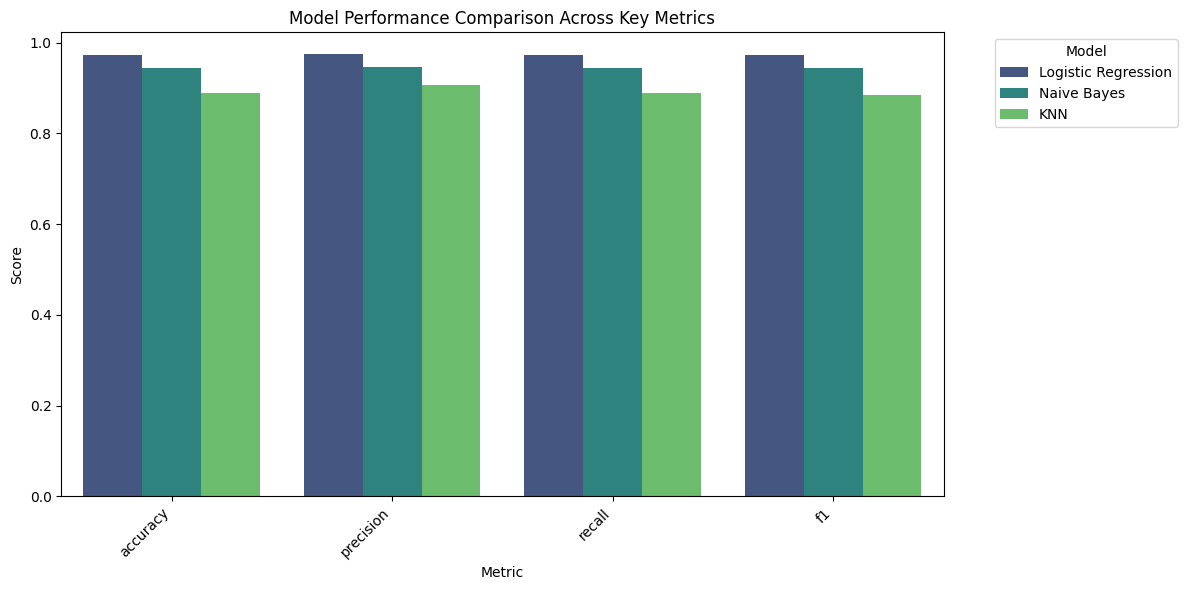


Based on F1-score, the best performing model is: Logistic Regression with an F1-score of 0.9720


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


metrics_to_plot = model_comparison_df.drop(columns=['confusion_matrix'], errors='ignore').reset_index()
metrics_to_plot = metrics_to_plot.rename(columns={'index': 'Model'})


melted_metrics = metrics_to_plot.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=melted_metrics, palette='viridis')
plt.title('Model Performance Comparison Across Key Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Identify the best performing model based on F1-score
best_model_name = model_comparison_df['f1'].idxmax()
best_model_f1 = model_comparison_df['f1'].max()

print(f"\nBased on F1-score, the best performing model is: {best_model_name} with an F1-score of {best_model_f1:.4f}")